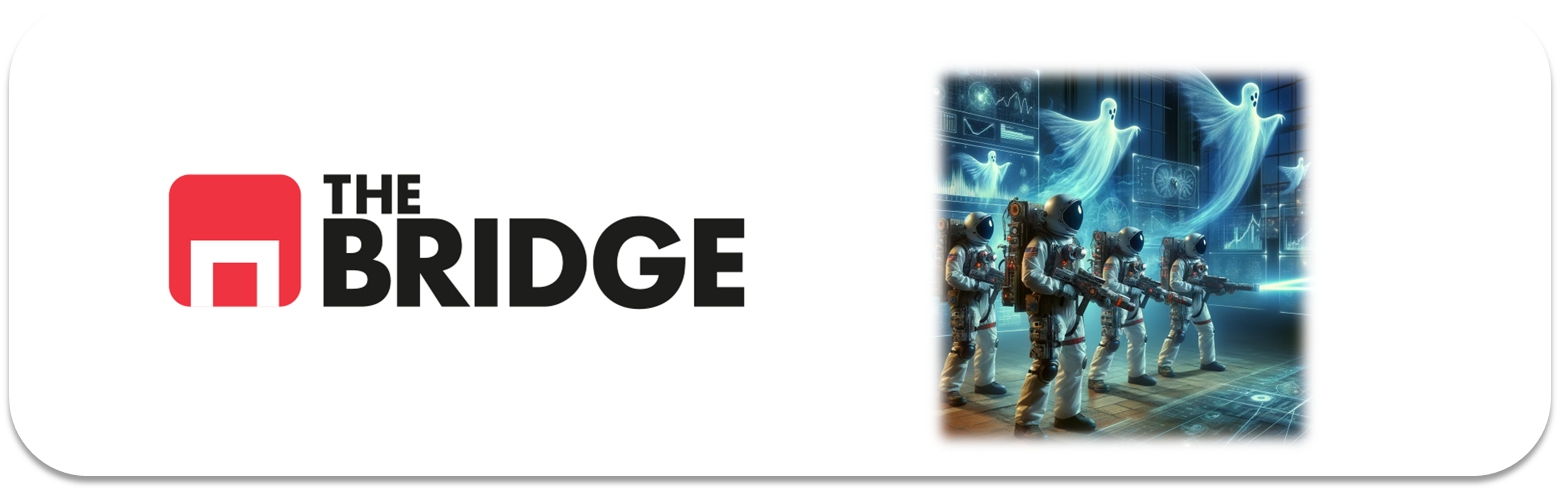

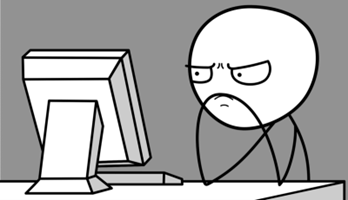

Para ejercitarte y afianzar lo aprendido sobre **Series Temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### El "problema"

Para este ejercicio vamos a `predecir cuál será la demanda de pasajeros de una aerolinea`, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [43]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Ejercicio 1

Carga los datos y adecúa el dataset teniendo en cuenta que es una serie temporal. Para ello convierte la columna de fecha al formato adecuado y luego úsala como índice.

In [2]:
df_passengers = pd.read_csv('./data/AirPassengers.csv')
df_passengers.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [3]:
df_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df_passengers['date'] = pd.to_datetime(df_passengers['date'])
df_passengers = df_passengers.sort_values('date').set_index('date')
df_passengers.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Ejercicio 2

¿De qué fecha a qué fecha va el histórico?¿Qué periodicidad tiene la serie?

In [5]:
print('Fecha mínima:', df_passengers.index.min(), '\nFecha máxima:', df_passengers.index.max())

Fecha mínima: 1949-01-01 00:00:00 
Fecha máxima: 1960-12-01 00:00:00


*Por el head del ejercicio anterior se ve que es una serie mensual que va de enero del 49 a diciembre del 60 del siglo XX*

### Ejercicio 3

¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad? Analiza de manera gráfica, pero todavía sin descomponer la serie.

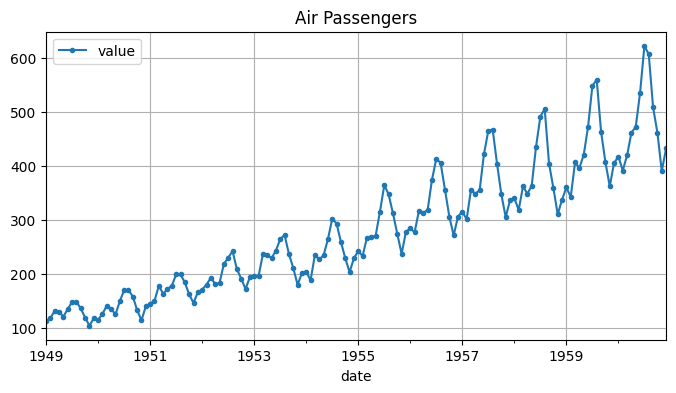

In [6]:
# Los límites en las fechas son inclusivos
df_passengers[:].plot(grid=True, marker=".", figsize=(8, 4))
plt.title('Air Passengers')
plt.show()

*A simple vista la serie tiene una tendencia ascendente que parece exponencial (fijate en como van subiendo los valores) y presenta estacionalidad, podemos deducirlo de las constantes repeticiones en el patrón de cantidad de pasajeros, teniendo ciertos picos que se repiten.* 

Por tanto, no parece una serie estacionaria.

*Parece una estacionalidad anual, por lo que vamos a pintar año a año superpuetos*

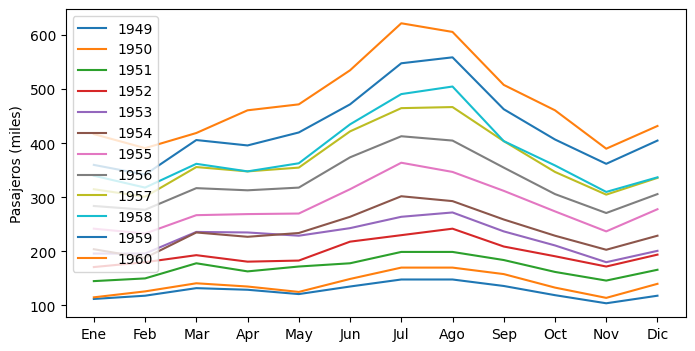

In [7]:
fig,axes = plt.subplots(1,1,figsize = (8, 4), sharex=True)

for year in range(1949, 1961):
    axes.plot(df_passengers.loc[f"{year}"]["value"].values, label=year)
    
plt.legend()
plt.ylabel("Pasajeros (miles)")
labels=["Ene","Feb","Mar","Apr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]
plt.xticks(ticks = range(0,12), labels=labels);

*Se ve claramente que tienen formas similares aunque los valores no lo sean y los picos en los meses de "verano" aumenten con los años. Podemos estimar que la estacionalidad es anual, con lo que si queremos ver la tendencia podríamos aplicar una media de ventana móvil de 12 meses (1 año):*

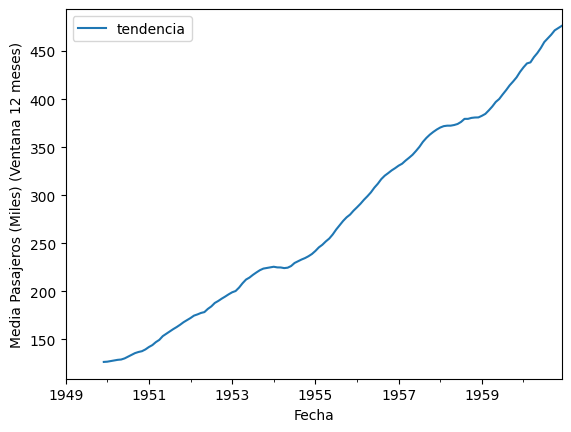

In [8]:
df_passengers.rolling(12).mean().rename(columns={"value": "tendencia"}).plot()

plt.xlabel("Fecha")
plt.ylabel("Media Pasajeros (Miles) (Ventana 12 meses)")
plt.legend();

### Ejercicio 4

¿Podrías demostrar de dos maneras estadísticas que la serie no es estacionaria?

In [9]:
# Método 1: Usando el resultado del test de Dickey-Fuller Aumentado
pvalue = adfuller(df_passengers['value'])[1]
pvalue

0.991880243437641

La hipótesis nula supone que la serie NO es estacionaria. 

El test supera el p-value 0.05 (con creces), no podemos rechazar la hipótesis nula de no estacionariedad, por lo tanto no es estacionaria.

*La segunda forma es yendo directamente a la definición, en la que nos dice que una serie estacionaria mantiene su media y varianza para cualquier periodo de tiempo, con demostrar que esto no se cumple para la media, nos llega*

In [16]:
# Método 2 
print(df_passengers['value'].iloc[:20].agg(['mean','median']))
print('-' * 30)
print(df_passengers['value'].iloc[60:100].agg(['mean','median']))
print('-' * 30)
print(df_passengers['value'].iloc[100:].agg(['mean','median']))

mean      132.55
median    130.50
Name: value, dtype: float64
------------------------------
mean      288.35
median    281.00
Name: value, dtype: float64
------------------------------
mean      421.068182
median    406.500000
Name: value, dtype: float64


Los estadísticos cambian notoriamente en el tiempo, por lo tanto no es estacionaria.

El último método es extrayendo tendencia y estacionalidad con la función *seasonal_decompose*. Aunque lo voy a repetir en el siguiente apartado porque es lo que se pide.

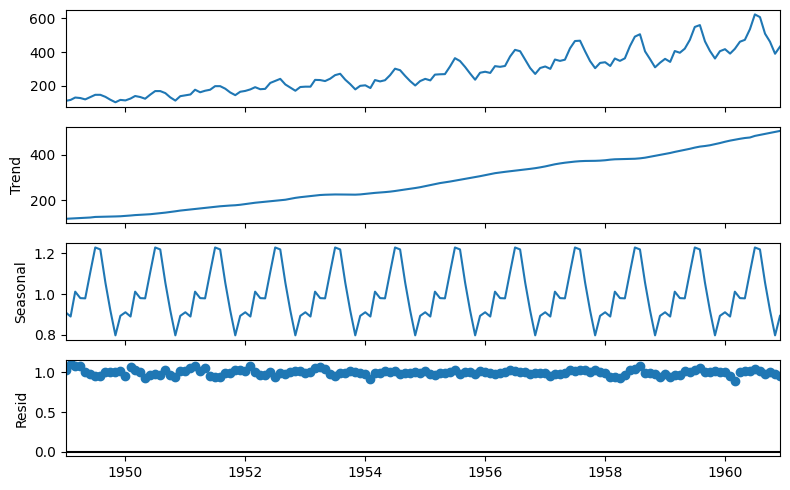

In [23]:
# Método 3 - Descomponer la serie temporal

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_passengers, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_passengers, model='additive', extrapolate_trend='freq')

# Plot del multiplicativo
plt.rcParams.update({'figure.figsize': (8, 5)})
result_mul.plot();

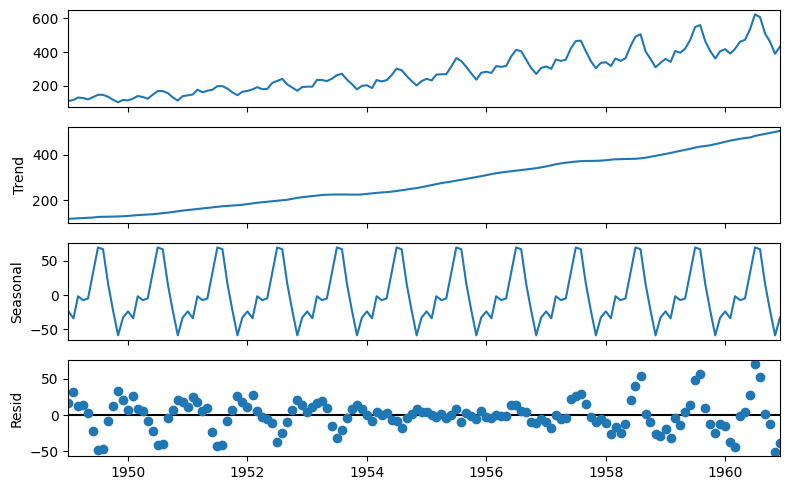

In [24]:
# Plot del aditivo
result_add.plot();

Aquí se ve claramente, en ambos modelos, que sí hay componente de tendencia y de estacionalidad.

### Ejercicio 5

Emplea la descomposición que hemos aprendido en el workout para representar gráficamente la tendencia. Si has mostrado gráficamente la tendencia en el ejercicio 3, compara ambos.

Es precisamente lo que he hecho al final del apartado anterior, pero aquí voy a volver a hacerlo.

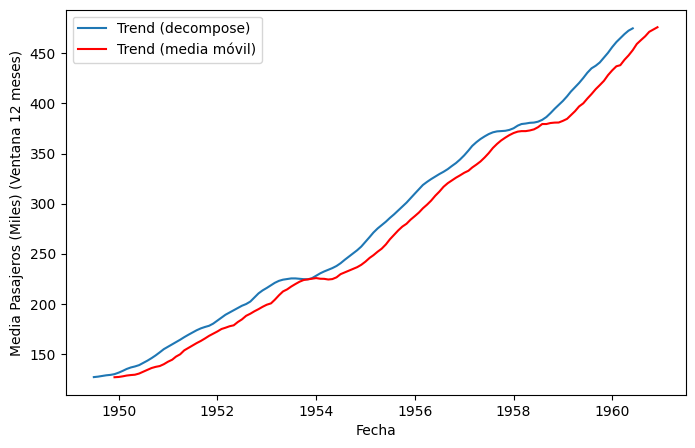

In [25]:
# Método Multiplicativo

result_multi = seasonal_decompose(df_passengers['value'], model='multiplicative', period=12)

plt.plot(result_multi.trend, label = "Trend (decompose)");
plt.plot(df_passengers.rolling(12).mean().rename(columns = {"value": "tendencia"}), color="red", label="Trend (media móvil)")
plt.xlabel("Fecha")
plt.ylabel("Media Pasajeros (Miles) (Ventana 12 meses)")
plt.legend();

*El método de descomposición multiplicativa es utilizado en este caso ya que la tendencia y estacionalidad cambian de manera exponencial y no uniforme.*

*Recordamos que diferenciando por su estacionalidad y obteniendo la media deducimos la tendencia, la estacionalidad en este caso la obtuvimos de manera visual del primer análisis aunque más adelante la deducimos a partir de una matriz de correlación.*

### Ejercicio 6

Visualiza todos los componentes de la serie temporal por separado

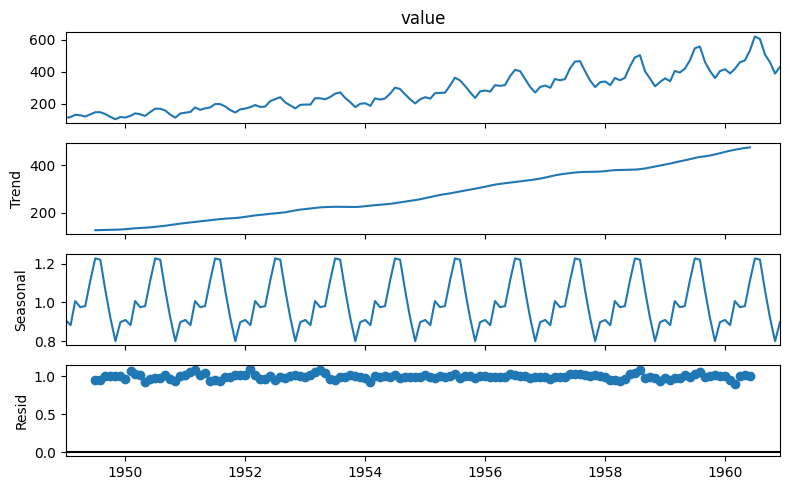

In [26]:
# Plot de componentes separadas
result_multi.plot();

*En este gráfico es muy fácil visualizar los componentes de tendencia y estacionalidad, se aprecian claramente al aislarlos.*

### Ejercicio 7

Crea una matriz de correlación con los últimos 24 instantes (matriz de autocorrelación). Crea un dataframe con shift de 1 a 24 para ello, la idea es que puedas hacer una matriz de correlación con el valor actual y los 24 valores anteriores. Es decir de un mes con sus 23 meses anteriores. Interpreta la estacionalidad

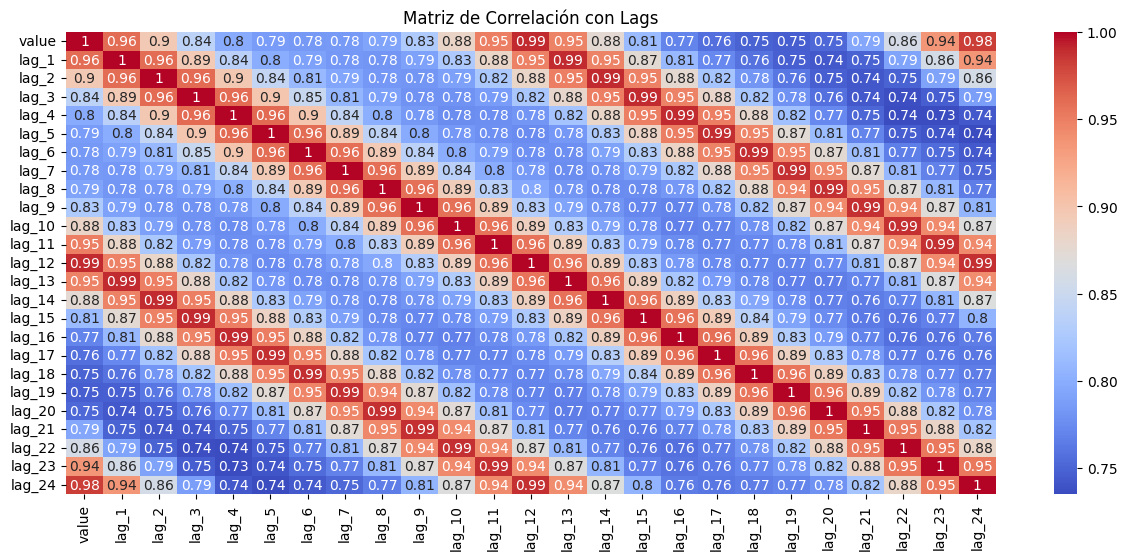

In [27]:
# Creamos columnas para los últimos 24 lags
df_autocorr = df_passengers.copy()

for lag in range(1, 25):
    df_autocorr[f'lag_{lag}'] = df_autocorr['value'].shift(lag)

# Calculamos la matriz de correlación
correlation_matrix = df_autocorr[['value'] + [f'lag_{lag}' for lag in range(1, 25)]].corr()

# Visualizamos la matriz de correlación
plt.figure(figsize=(15,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación con Lags')
plt.show()

*Si observas las correlaciones vs value (el valor actual), cada 12 instantes se observa un aumento de correlación, por ejemplo la correlación actual crece con el lag 12 y con el lag 24, esto indica una estacionalidad cada 12 instantes o anual en este caso. Básicamente la estacionalidad es esa autocorrelación que existe en una serie entre periodos equivalentes, en este caso los meses de enero correlan con los meses de enero. En el caso de tener una estacionalidad semanal (no para este dataset) entonces lo que correlarían sería los datos de cada día de la semana (como lo que correlan son los datos de la serie temporal consigo misma, por eso se le denomina autocorrelación y toda serie de valores que tenga "Periodos" repetidos muestra autocorrelación*

### Ejercicio 8
Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

*El patrón de autocorrelación se cumple cada 12,24,36,... lags, es decir estacionalidad anual, como ya habíamos deducido gráficamente*

### Ejercicio 9

 Divide en train y test. En este caso no haremos división en validación, entre otras razones por la cantidad de datos que tenemos. Guarda 20 muestras para test.

In [28]:
# Con iloc
train = df_passengers['value'].iloc[:-20]
test = df_passengers['value'].iloc[-20:]

In [29]:
train

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1958-12-01    337
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
Name: value, Length: 124, dtype: int64

In [31]:
len(test)

20

In [ ]:
# Con periodos de tiempo
# train = df_passengers[:"1959-04"]
# test = df_passengers["1959-05":]

### Ejercicio 10

Pon en práctica lo visto en clases, crea un modelo de ARIMA (puedes utilizar autoarima), mide su RMSE y su MAPE. Comparalo gráficamente con los valores reales.

El primer método será sin AutoARIMA

In [37]:
# Método 1: ARIMA (sin Auto-ARIMA)

p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
pdq[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4)]

In [39]:
results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima.fit(train)
        results.append((param, model_arima.aic()))
    except:
        continue
    
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()


,ARIMA params,AIC
83,"(3, 1, 3)",1119.169869
108,"(4, 1, 3)",1127.983484
34,"(1, 1, 4)",1133.159473
114,"(4, 2, 4)",1134.016377
107,"(4, 1, 2)",1134.574400


Aquí muestro los mejores resultados para AIC. Lo correcto sería probar varios valores para el ARIMA

In [41]:
resultados_df['ARIMA params'].iloc[0]

(3, 1, 3)

ARIMA Params = (3, 1, 3)
RMSE: 77.21485046428965
MAPE: 10.78%


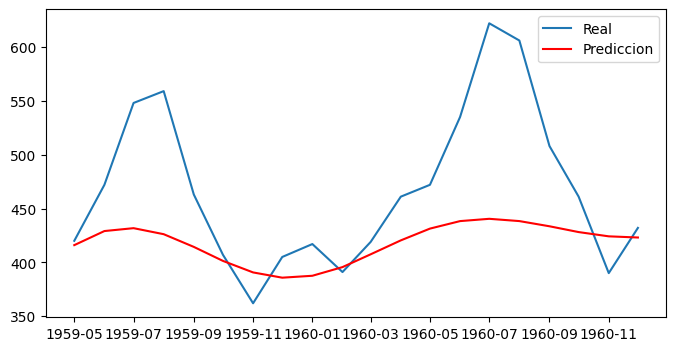

ARIMA Params = (4, 1, 3)
RMSE: 81.55321275685681
MAPE: 11.97%


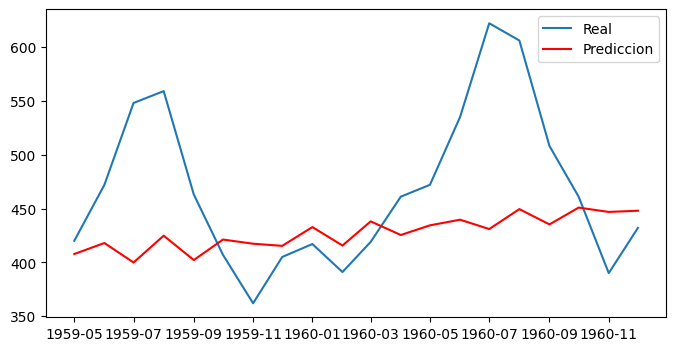

ARIMA Params = (1, 1, 4)
RMSE: 82.25082462472442
MAPE: 12.11%


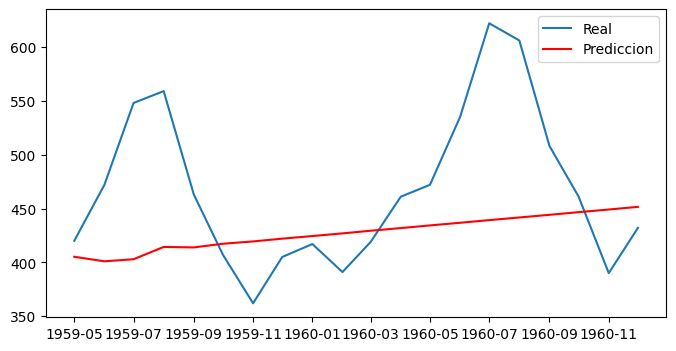

In [48]:
for i in range(3):

    print(f'ARIMA Params = {resultados_df['ARIMA params'].iloc[i]}')
    
    model_arima = ARIMA(order=resultados_df['ARIMA params'].iloc[i])
    model_arima.fit(train)

    # Resultados
    predictions = model_arima.predict(20) 
    error_rmse = np.sqrt(mean_squared_error(test, predictions))
    error_mape = mean_absolute_percentage_error(test, predictions)

    print(f'RMSE: {error_rmse}')
    print(f"MAPE: {round(error_mape * 100,2)}%")

    # Plot
    plt.figure(figsize = (8, 4))
    plt.plot(test, label = "Real")
    plt.plot(predictions, color='red', label = "Prediccion")
    plt.legend()
    plt.show();


Justo en este caso el mejor resultado (mejor MAPE) es para ARIMA Params = (3, 1, 3), pero ojo, porque ha sido un resultado bastante nefasto.

Vamos a probar el Auto-ARIMA.

In [56]:
# Método 2: Auto-ARIMA, sin seasonality
# Recordar que stepwise está a True por defecto
model_auto_ar = auto_arima(train,
                           start_p=1,
                           start_q=1,
                           max_p=5,
                           max_q=5,
                           max_d=3,
                           trace=True,
                           stepwise=True) 


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1164.464, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1180.340, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1174.338, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1171.576, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1179.124, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1171.757, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1163.079, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1170.015, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1172.799, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1156.122, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1170.365, T

El Auto-Arima ha escogido unos parámetros diferentes a los que hemos obtenido anteriormente... pero no tengo claro por qué.

In [60]:
print(model_auto_ar.order)
print(model_auto_ar.aic())
# print(model_auto_ar.params())


(5, 1, 3)
1144.102872570427


RMSE: 113.15721963481747
MAPE: 17.15%


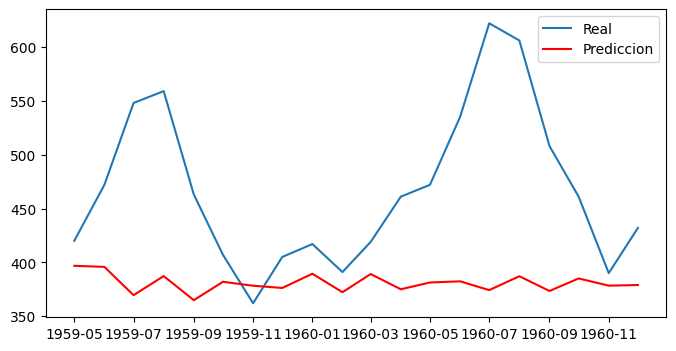

In [62]:
# Resultados
predictions = model_auto_ar.predict(20)
error_rmse = np.sqrt(mean_squared_error(test, predictions))
error_mape = mean_absolute_percentage_error(test, predictions)
print(f'RMSE: {error_rmse}')
print(f"MAPE: {round(error_mape * 100,2)}%")

# Plot
plt.figure(figsize = (8, 4))
plt.plot(test, label = "Real")
plt.plot(predictions, color='red', label = "Prediccion")
plt.legend();

El MAPE ha empeorado respecto a antes y la predicción es malísima.

### Ejercicio 11

Haz lo mismo que en el ejercicio 10 pero con un modelo SARIMA. ¿Cuál es mejor y por qué?

In [63]:
# Seasonal-ARIMA

# Frecuencia de estacionalidad anual (m=12)
model_auto_sar = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 12, 
                    trace=True,
                    stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=942.581, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=841.692, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=890.316, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1100.615, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=841.349, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=841.921, Time=0.48 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=841.844, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=842.275, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=889.425, Time=0.06 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=842.600, Time=0.30 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=849.916, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 4.315 seconds


RMSE: 113.15721963481747
MAPE: 5.86%


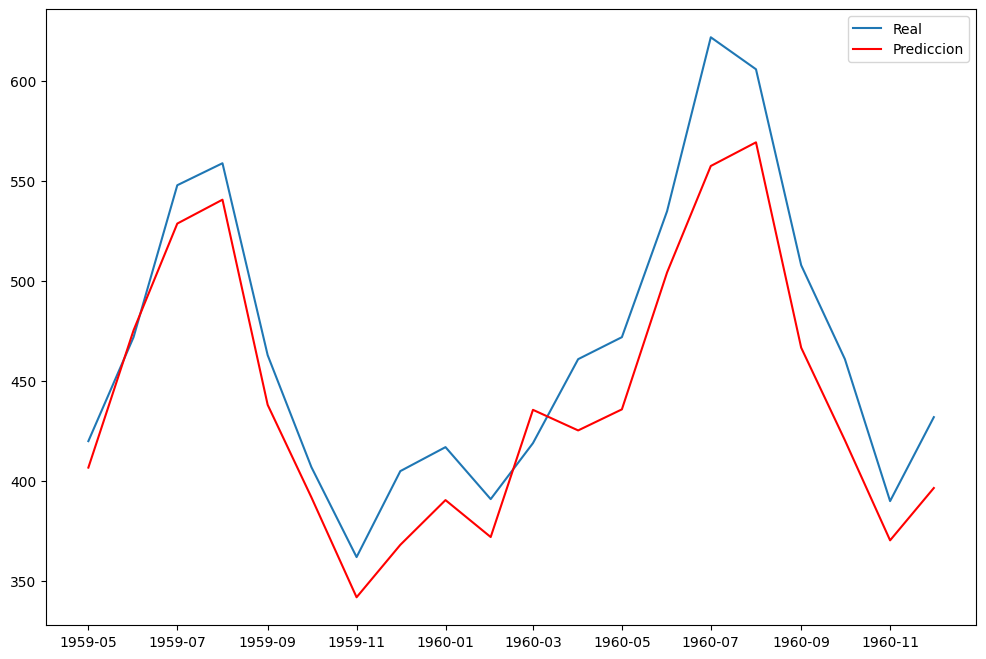

In [64]:
# Resultados
predictions = model_auto_sar.predict(20)
error = np.sqrt(mean_squared_error(test, predictions))
error_mape = mean_absolute_percentage_error(test, predictions)

print(f'RMSE: {error_rmse}')
print(f"MAPE: {round(error_mape * 100,2)}%")

# Plot
plt.figure(figsize = (12,8))
plt.plot(test, label = "Real")
plt.plot(predictions, color='red', label = "Prediccion")
plt.legend();

*Utilizamos los rangos comunes para ARIMA en cada uno de los parámetros (p, d, q), sin embargo lo que marca la diferencia en perfomance principalmente es el haber detectado correctamente la estacionalidad y frecuencia durante nuestro análisis de datos.*